# pbh

> A module to model and calculate the properties of primordial black holes (PBHs), such as density, mass, distance, and velocity distribution.

In [ ]:
#| default_exp pbh

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from LensCalcPy.parameters import *
from LensCalcPy.utils import *
from LensCalcPy.lens import *
from LensCalcPy.galaxy import *

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import erf
from scipy.integrate import nquad, dblquad, tplquad
from scipy.optimize import minimize_scalar, fsolve, brentq
from scipy.integrate import quad


from scipy.interpolate import interp1d, interp2d, RegularGridInterpolator
from tqdm import tqdm
# from multiprocessing import Pool
from pathos.multiprocessing import ProcessingPool as Pool
import functools
import pickle
from abc import ABC, abstractmethod

from fastcore.test import *

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
plt.style.use("../examples/style.mplstyle")
sns.set_palette("colorblind")


In [ ]:
#| export


class Pbh(Lens):
    """A class to represent a PBH population"""

    def __init__(self,
                mass: float, # PBH mass in solar masses
                f_dm: float, # PBH fraction of the DM density
                mw_model=None,
                m31_model=None,
                l = None,
                b = None,
                u_t = 1,
                ds = 770,
                lognorm=False,
                sigma=None,
                ut_interp = None,
                ):
        """
        Initialize the PBH population
        """

        self.mw_model = mw_model or MilkyWayModel(mw_parameters)
        self.m31_model = m31_model or M31Model(m31_parameters)
        
        if l is None:
            raise ValueError("Galactic longitude must be specified")
        if b is None:
            raise ValueError("Galactic latitude must be specified")
        self.l = l
        self.b = b

        self.mass = mass
        if f_dm < 0 or f_dm > 1:
            raise ValueError("f_dm must be between 0 and 1")
        self.f_dm = f_dm
        # self.ut_interp = ut_interp
        if ut_interp is None:
            self.ut_interp = ut_func_new
        else:
            self.ut_interp = ut_interp
        self.u_t = u_t
        self.ds = ds
        self.lognorm = lognorm
        if self.lognorm and sigma is None:
            raise ValueError("Sigma must be specified for lognormal mass function")
        self.sigma = sigma
    
    def __str__(self) -> str:
        return f"PBH population with mass={self.mass} and f_dm={self.f_dm}"
    __repr__ = __str__

    def mass_function(self, m):
        """The mass function of the PBH population"""
        if not self.sigma or not self.lognorm:
            raise ValueError("Lognormal mass function not initialized")
        return 1 / (m * self.sigma * np.sqrt(2 * np.pi)) * np.exp(-(np.log(m/self.mass))**2 / (2 * self.sigma**2))

    def differential_rate_integrand(self, umin, d, t, model, finite=False, v_disp=None, t_e = False, tmax=np.inf, tmin=0, t_fwhm=False):

        r = model.dist_center(d, self.l, self.b)
        ut = self.umin_upper_bound(d) if finite else self.u_t
        if ut <= umin:
            return 0
        if t_fwhm:
            t_E = t_e_from_fwhm(t, umin, finite, rho_func(self.mass, d, self.ds))
            v_rad = einstein_rad(d, self.mass, self.ds) * kpctokm / (t_E * htosec)
        else:
            #Calculate radial velocity in terms of event duration (t_fwhm)
            v_rad = velocity_radial(d, self.mass, umin, t * htosec, ut, self.ds) 
        if v_disp is None: 
            v_disp = model.velocity_dispersion_dm(r)
            # v_disp = model.velocity_dispersion_nfw(r)

        return 2 * (1 / (ut**2 - umin**2)**0.5 *
                model.density_dm(d, self.l, self.b) / (self.mass * v_disp**2) *  
                v_rad**4 * (htosec / kpctokm)**2 *
                np.exp(-(v_rad**2 / v_disp**2)) *
                1)

    def differential_rate_integrand_mw(self, umin, d, t, finite=False, t_fwhm=False):
        return self.differential_rate_integrand(umin, d, t, self.mw_model, finite=finite, t_fwhm=t_fwhm)
    
    def differential_rate_integrand_m31(self, umin, d, t, finite=False, t_fwhm=False):
        return self.differential_rate_integrand(umin, d, t, self.m31_model, finite=finite, t_fwhm=t_fwhm)
    
    def differential_rate(self, t, integrand_func, finite=False, epsabs=1.49e-08, epsrel=1.49e-08):

        def inner_integrand(u, d, t):
            return integrand_func(u, d, t)
        
        # Second integral (over u) - bounds given by d
        def second_integral(d, t):
            if finite:
                u_min, u_max = 0, self.umin_upper_bound(d)[0]
            else:
                u_min, u_max = 0, self.u_t

            result, error = quad(inner_integrand, u_min, u_max, args=(d, t), epsabs=epsabs, epsrel=epsrel)

            return result
        
        # Outermost integral (over d)
        d_min, d_max = 0, self.d_upper_bound() if finite else self.ds
        result, error = quad(second_integral, d_min, d_max, args=(t,), epsabs=epsabs, epsrel=epsrel)
        return result

    def rate_total(self, integrand_func, finite=True, tcad=0.07, tobs=3, epsabs = 1.49e-08, epsrel = 1.49e-08, efficiency=None):        

        # Innermost double integral
        def inner_integrand(u, d, t):
            return integrand_func(u, d, t)
        
        # Second integral (over u) - bounds given by d
        def second_integral(d, t):
            if finite:
                u_min, u_max = 0, self.umin_upper_bound(d)
            else:
                u_min, u_max = 0, self.u_t

            result, error = quad(inner_integrand, u_min, u_max, args=(d, t), epsabs=epsabs, epsrel=epsrel)

            return result
        
        # Outermost integral (over d)
        def outer_integral(t):
            d_min, d_max = 0, self.d_upper_bound() if finite else self.ds

            result, error = quad(second_integral, d_min, d_max, args=(t,), epsabs=epsabs, epsrel=epsrel)
            # return result * self.mass_function(mf) * mf * np.log(10)  # multiply by mass function and by dlogm * m
            return result  
                
        # Integrate over time
        result, error = quad(outer_integral, tcad, tobs, epsabs=epsabs, epsrel=epsrel)
        return result
    
    
    def d_upper_bound(self, m=None):
        if m is None:
            m = self.mass
        #Determine upper limit for d otherwise for low masses, the contribution which only comes from d << 1 gets missed
        d_arr = np.logspace(-3, np.log10(self.ds*0.99), 100)
        for d in d_arr:
            if self.umin_upper_bound(d,m=m) == 0:
                return d
        return self.ds
    
    def rate_mw(self, finite=True, tcad = 0.07, tobs = 3, efficiency=None, epsabs = 1.49e-08, epsrel = 1.49e-08, t_fwhm=False):
        def integrand_func(umin, d, t):
            return self.differential_rate_integrand_mw(umin, d, t, finite=finite, t_fwhm=t_fwhm)
        return self.rate_total(integrand_func, finite=finite, tcad=tcad, tobs=tobs, efficiency=efficiency, epsabs=epsabs, epsrel=epsrel)
    
    def rate_m31(self, finite=True, tcad = 0.07, tobs = 3, efficiency=None, epsabs = 1.49e-08, epsrel = 1.49e-08, t_fwhm=False):
        def integrand_func(umin, d, t):
            return self.differential_rate_integrand_m31(umin, d, t, finite=finite, t_fwhm=t_fwhm)
        # result = self.rate_total(self.differential_rate_integrand_m31, finite=finite)
        result = self.rate_total(integrand_func, finite=finite, tcad=tcad, tobs=tobs, efficiency=efficiency, epsabs=epsabs, epsrel=epsrel)
        if not np.isnan(result):
            return result
        else:
            return 0
        
    def rate_tot(self, finite=True, tcad = 0.07, tobs = 3, efficiency=None, epsabs = 1.49e-08, epsrel = 1.49e-08, t_fwhm=False):
        rate_mw = self.rate_mw(finite=finite, tcad=tcad, tobs=tobs, efficiency=efficiency, epsabs=epsabs, epsrel=epsrel, t_fwhm=t_fwhm)
        rate_m31 = self.rate_m31(finite=finite, tcad=tcad, tobs=tobs, efficiency=efficiency, epsabs=epsabs, epsrel=epsrel, t_fwhm=t_fwhm)
        return rate_mw + rate_m31
        # return self.rate_mw(finite=finite) + self.rate_m31(finite=finite)
    
    def differential_rate_mw(self, t, finite=True, v_disp=None, t_e=False, tmax=np.inf, tmin=0, t_fwhm=False):
        def integrand_func(umin, d, t):
            return self.differential_rate_integrand(umin, d, t, self.mw_model, finite=finite, v_disp=v_disp, t_e = t_e, tmax=tmax, tmin=tmin, t_fwhm=t_fwhm)
        return self.differential_rate(t, integrand_func, finite=finite)
    
    def differential_rate_m31(self, t, finite=True, v_disp=None, t_fwhm=False):
        def integrand_func(umin, d, t):
            return self.differential_rate_integrand(umin, d, t, self.m31_model, finite=finite, v_disp=v_disp, t_fwhm=t_fwhm)
        return self.differential_rate(t, integrand_func, finite=finite)

    def umin_upper_bound(self, d, m=None):
        if m is None:
            m = self.mass
        rho = rho_func(m, d, self.ds)
        return self.ut_interp(rho, magnification(self.u_t))
    
    def differential_rate_total(self, t, finite=True, t_fwhm=False):
        return self.differential_rate_mw(t, finite=finite, t_fwhm=t_fwhm) + self.differential_rate_m31(t, finite=finite, t_fwhm=t_fwhm)
 
    def compute_differential_rate(self, ts, finite=True, t_fwhm=False):
        return [self.differential_rate_total(t, finite=finite, t_fwhm=t_fwhm) for t in ts]
    
    def sticking_point(self):
        #Determine where u_t is maximized. This speeds up the integral in m31
        result = minimize_scalar(lambda d: -self.umin_upper_bound(d), bounds=(0, self.ds), method='bounded')
        if result.success:
            return result.x[0] if isinstance(result.x, (list, np.ndarray)) else result.x
        else:
            return self.ds
    
    def differential_rate_integrand_lognorm(self, umin, d, t, mf, model, finite=False, v_disp=None, t_e = False, tmax=np.inf, tmin=0):

        r = model.dist_center(d, self.l, self.b)
        ut = self.umin_upper_bound(d) if finite else self.u_t
        if ut <= umin:
            return 0 
        
        #Calculate radial velocity in terms of event duration 
        v_rad = velocity_radial(d, mf, umin, t * htosec, ut, self.ds) 
        if v_disp is None: 
            v_disp = model.velocity_dispersion_dm(r)
        # if v_rad/v_disp > 10:
            # return 0
        return 2 * (1 / (ut**2 - umin**2)**0.5 *
                model.density_dm(d, self.l, self.b) / (mf * v_disp**2) *  
                v_rad**4 * (htosec / kpctokm)**2 *
                np.exp(-(v_rad**2 / v_disp**2)) *
                1)
    
    def differential_rate_lognorm(self, t, integrand_func, finite=False, epsabs=1.49e-08, epsrel=1.49e-08):
    
        # Innermost double integral
        def inner_integrand(u, d, mf, t):
            return integrand_func(u, d, mf, t)
        
        # Second integral (over u) - bounds given by d
        def second_integral(d, mf, t):
            if finite:
                u_min, u_max = 0, self.umin_upper_bound(d, mf)[0]
            else:
                u_min, u_max = 0, self.u_t

            if 2/3 * u_max**2 < self.mw_model.velocity_dispersion_dm(self.mw_model.dist_center(d, self.l, self.b))**2:
                local_max = u_max
            else:
                local_max = 1.22* (2/3*u_max**2 - self.mw_model.velocity_dispersion_dm(self.mw_model.dist_center(d, self.l, self.b))**2)**(1/2)
            
            # result, error = quad(inner_integrand, u_min, u_max, args=(d, mf, t), epsabs=epsabs, epsrel=epsrel, points=[0, u_max/2, 1], limit=3)
            result, error = quad(inner_integrand, u_min, u_max, args=(d, mf, t), epsabs=epsabs, epsrel=epsrel, points=[local_max])

            return result
        
        # Outermost integral (over d)
        def outer_integral(mf, t):
            d_min, d_max = 0, self.d_upper_bound(mf) if finite else self.ds
            result, error = quad(second_integral, d_min, d_max, args=(mf, t), epsabs=epsabs, epsrel=epsrel)
            # return result * self.mass_function(mf) * mf * np.log(10)  # multiply by mass function and by dlogm * m
            return result * self.mass_function(mf)   

        # Integrate over mass
        mf_min, mf_max = 10**(np.log10(self.mass) - 3 * self.sigma), 10**(np.log10(self.mass) + 3 * self.sigma)
        result, error = quad(outer_integral, mf_min, mf_max, args=(t,), epsabs=epsabs, epsrel=epsrel)
        
        return result
    
    def differential_rate_mw_lognorm(self, t, finite=True, v_disp=None, t_e=False, tmax=np.inf, tmin=0, epsabs = 1.49e-08, epsrel = 1.49e-08):
        def integrand_func(umin, d, mf, t):
            return self.differential_rate_integrand_lognorm(umin, d, t, mf, self.mw_model, finite=finite, v_disp=v_disp, t_e = t_e, tmax=tmax, tmin=tmin)
        return self.differential_rate_lognorm(t, integrand_func, finite=finite, epsabs = epsabs, epsrel = epsrel)

    
    def differential_rate_integrand_new(self, umin, d, model, finite=False, v_disp=None, tcad = 0.07, tobs = 3, t_fwhm=False):

        #Analytically perform integral over t
        r = model.dist_center(d, self.l, self.b)
        ut = self.umin_upper_bound(d) if finite else self.u_t
        if ut <= umin:
            return 0
        if v_disp is None: 
            v_disp = model.velocity_dispersion_dm(r)

        if t_fwhm:
            ut = u_fwhm_interp([rho_func(self.mass, d, self.ds), umin])[0]

        A = 2/(ut**2 - umin**2)**0.5 * model.density_dm(d, self.l, self.b) / (self.mass * (v_disp*htosec/kpctokm)**2 ) * (2 * einstein_rad(d, self.mass, self.ds)* (ut**2 - umin**2)**0.5)**4 
        B = (2*einstein_rad(d, self.mass, self.ds)  * (ut**2 - umin**2)**0.5)**2 / (v_disp*htosec/kpctokm)**2

        def integral_t(t):
            # return A/(2*B) * (np.exp(-B/t**2 )/t - np.pi**(1/2) * erf(B**(1/2)/t) /(2* B**(1/2)))
            return A*(np.exp(-B/t**2 )/(2*B*t) - np.pi**(0.5) * erf(B**(0.5)/t) /(4* B**(1.5)))

        return integral_t(tobs) - integral_t(tcad)
    
    def rate_total_new(self, integrand_func, finite=True, tcad=0.07, tobs=3, epsabs = 1.49e-08, epsrel = 1.49e-08, efficiency=None):        

        # Innermost double integral
        def inner_integrand(u, d):
            return integrand_func(u, d)
        
        # Second integral (over u) - bounds given by d
        def second_integral(d):
            if finite:
                u_min, u_max = 0, self.umin_upper_bound(d)[0]
            else:
                u_min, u_max = 0, self.u_t            
            result, error = quad(inner_integrand, u_min, u_max, args=(d), epsabs=epsabs, epsrel=epsrel)

            return result
        
        # Outermost integral (over d)
        d_min, d_max = 0, self.d_upper_bound() if finite else self.ds
        result, error = quad(second_integral, d_min, d_max, epsabs=epsabs, epsrel=epsrel)
        return result  
    
    def rate_mw_new(self, finite=True, tcad = 0.07, tobs = 3, efficiency=None, epsabs = 1.49e-08, epsrel = 1.49e-08, t_fwhm=False):
        def integrand_func(umin, d):
            return self.differential_rate_integrand_new(umin, d, self.mw_model, finite=finite, tcad=tcad, tobs=tobs, t_fwhm=t_fwhm)
        return self.rate_total_new(integrand_func, finite=finite, tcad=tcad, tobs=tobs, efficiency=efficiency, epsabs=epsabs, epsrel=epsrel)
    
    def rate_m31_new(self, finite=True, tcad = 0.07, tobs = 3, efficiency=None, epsabs = 1.49e-08, epsrel = 1.49e-08, t_fwhm=False):
        def integrand_func(umin, d):
            return self.differential_rate_integrand_new(umin, d, self.m31_model, finite=finite, tcad=tcad, tobs=tobs, t_fwhm=False)
        result = self.rate_total_new(integrand_func, finite=finite, tcad=tcad, tobs=tobs, efficiency=efficiency, epsabs=epsabs, epsrel=epsrel)
        if not np.isnan(result):
            return result
        else:
            return 0
    
    def rate_tot_new(self, finite=True, tcad = 0.07, tobs = 3, efficiency=None, epsabs = 1.49e-08, epsrel = 1.49e-08, t_fwhm=False):
        rate_mw = self.rate_mw_new(finite=finite, tcad=tcad, tobs=tobs, efficiency=efficiency, epsabs=epsabs, epsrel=epsrel, t_fwhm=t_fwhm)
        rate_m31 = self.rate_m31_new(finite=finite, tcad=tcad, tobs=tobs, efficiency=efficiency, epsabs=epsabs, epsrel=epsrel, t_fwhm=t_fwhm)
        return rate_mw + rate_m31
        # return self.rate_mw(finite=finite) + self.rate_m31(finite=finite)
         

In [ ]:
m_lens = 3e-5
pbh = Pbh(m_lens, 1, l=l, b=b, ds=ds, lognorm=True, sigma=0.1)
# pbh = Pbh(m_lens, 1, l=1.0, b=-1.03, ds=8.5, lognorm=True, sigma=0.1, u_t=1)

ts = np.logspace(-2,1,50)

In [ ]:
pbh.rate_mw_new(epsabs=0, epsrel=1e-1, tcad=0.07, tobs=100, finite=True)

2.7384615867469513e-08

In [ ]:
def opt_depth_integrand(d):
    return (pbh.mw_model.density_dm(d, l, b) + pbh.m31_model.density_dm(d, l, b))/pbh.mass * np.pi * einstein_rad(d, pbh.mass, pbh.ds)**2
d_arr = np.logspace(-3, np.log10(pbh.ds*0.99), 1000)
opt_depth_arr = np.array([quad(opt_depth_integrand, 0, d)[0] for d in d_arr])

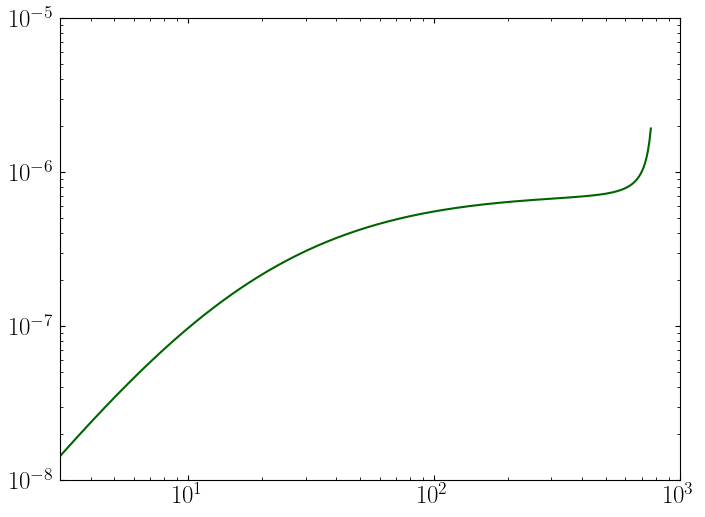

In [ ]:
plt.loglog(d_arr, opt_depth_arr, color='darkgreen')
plt.ylim(1e-8, 1e-5)
plt.xlim(3, 1e3)
plt.show()

In [ ]:
pbh_wide = Pbh(m_lens, 1, l=1.0, b=-1.03, ds=8.5, lognorm=True, sigma=1.)
pbh_med = Pbh(m_lens, 1, l=1.0, b=-1.03, ds=8.5, lognorm=True, sigma=0.5)


In [ ]:
m_arr = np.logspace(-12, -1, 10000)
mass_func_arr = np.array([pbh.mass_function(m) for m in m_arr])
mass_func_arr_wide = np.array([pbh_wide.mass_function(m) for m in m_arr])
mass_func_arr_med = np.array([pbh_med.mass_function(m) for m in m_arr])


<matplotlib.legend.Legend>

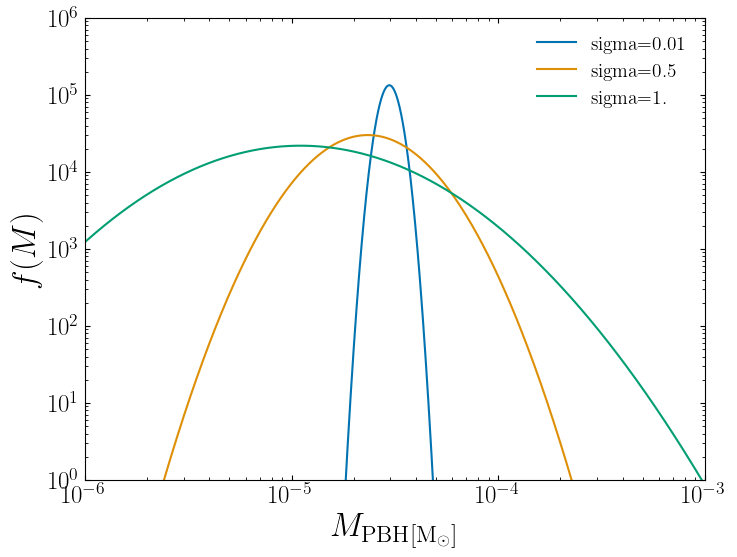

In [ ]:
plt.loglog(m_arr, mass_func_arr, label="sigma=0.01")
plt.loglog(m_arr, mass_func_arr_med, label="sigma=0.5")
plt.loglog(m_arr, mass_func_arr_wide, label="sigma=1.")
plt.ylim(1e0, 1e6)
plt.xlim(1e-6, 1e-3)
plt.xlabel(r"$M_{\rm{PBH} [M_{\odot}]}$")
plt.ylabel(r'$f(M)$')
plt.legend()
# plt.savefig("../examples/figures/log_norm_mass_func.pdf")


In [ ]:
#test object creation
test_eq(pbh.mass, m_lens)

#test differential rate
test_eq(pbh.differential_rate_total(1), pbh.differential_rate_mw(1) + pbh.differential_rate_m31(1))

#test that threshold parameter is close to 1 for small d
test_close(pbh.umin_upper_bound(0), 1, eps=1e-2)

#test that threshold parameter is close to 0 when close to source
test_close(pbh.umin_upper_bound(ds*0.99999), 0, eps=1e-2)

#test that umin lower bound is correctly inherited from Lens
test_eq(pbh.umin_lower_bound(0), 0)

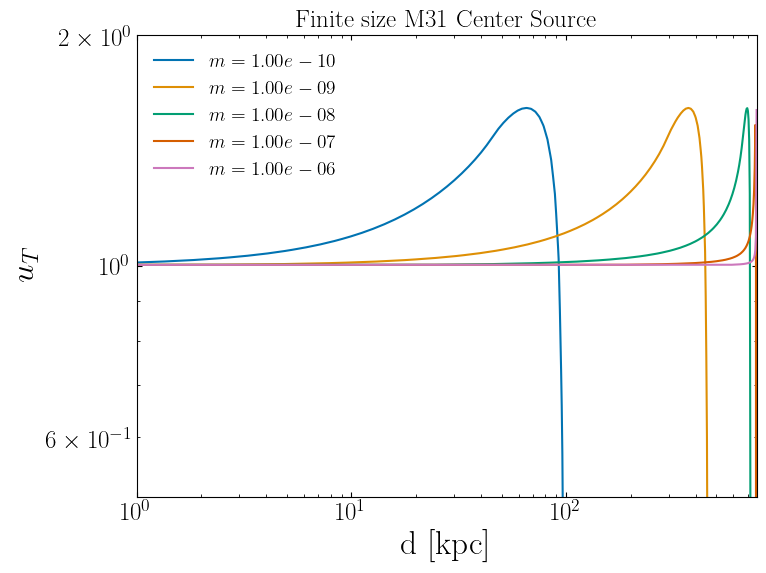

In [ ]:
d_arr = np.logspace(0, np.log10(ds*0.999), 1000)

m_pbh_arr = np.logspace(-10, -6, 5)

rhos_calc = [[rho_func(m, d, ds) for d in d_arr] for m in m_pbh_arr]

for m, rhos in zip(m_pbh_arr, rhos_calc):
    plt.plot(d_arr, ut_func_new(rhos, 1.34), label=f"$m= {m:.2e}$")

plt.xscale("log")
plt.yscale("log")
plt.xlim(min(d_arr), max(d_arr))
plt.ylim(5e-1, 2)

plt.xlabel("d [kpc]")
plt.ylabel("$u_{T}$")
plt.title("Finite size M31 Center Source")

plt.legend()
plt.show()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()